In [260]:
# load and show dataset
import pandas as pd

file_path = 'RandomForest Datenset 1.csv'
data = pd.read_csv(file_path, sep = "\t").dropna()
print(data['Charge'].value_counts())

data

Charge
2    78454
1    35452
3    26913
4     3294
Name: count, dtype: int64


,Sequence,Charge,Mass,Length,CCS,NumRotatableBonds,NumConformers,NumAtoms,FractionSP3
0,AAAAAAAAAAAATGTEAGPGTAGGSENGSEVAAQPAGLSGPAEVGPGAVGER,4,4401.106890,52,2.654046e-35,134.0,0.0,309.0,0.668508
1,AAAAAAAAAK,1,785.439552,10,5.981752e-36,23.0,0.0,55.0,0.696970
2,AAAAAAAAAPAAAATAPTTAATTAATAAQ,2,2367.203020,29,1.208337e-35,64.0,0.0,166.0,0.696970
3,AAAAAAAAAPAAAATAPTTAATTAATAAQ,3,2367.203020,29,2.200959e-35,64.0,0.0,166.0,0.696970
4,AAAAAAAK,1,643.365324,8,6.811654e-36,19.0,0.0,45.0,0.703704
...,...,...,...,...,...,...,...,...,...
144112,YYYNCRTEVSQWEK,3,1924.841400,14,2.846427e-35,58.0,0.0,132.0,0.464286
144113,YYYNCRTEVSQWEKPK,3,2149.989120,16,2.854486e-35,65.0,0.0,148.0,0.505263
144114,YYYQGCASWK,2,1324.554660,10,1.742139e-35,36.0,0.0,90.0,0.383333
144115,YYYVCQYCPAMKTYLNK,3,2264.010450,17,2.726609e-35,64.0,0.0,150.0,0.510000


In [261]:
# Schritt 1: Nach Sequenzen gruppieren
grouped = data.groupby("Sequence")

# Erstellen einer Liste, in der jede Sequenz eine Gruppe ist
grouped_data = [(seq, group) for seq, group in grouped]

In [262]:
# splitting
from sklearn.model_selection import train_test_split

# X_unscaled = data.drop(columns=['CCS', 'Sequence', 'NumConformers'])
# y_unscaled = data['CCS']

train_groups, test_groups = train_test_split(grouped_data, test_size = 0.2, random_state=42)

# Schritt 3: Die Gruppendaten wieder in DataFrames konvertieren
train_df = pd.concat([group for _, group in train_groups])
test_df = pd.concat([group for _, group in test_groups])
# train_df = train_groups
# test_df = test_groups

In [263]:
len(train_df)

115284

In [264]:
len(test_df)

28829

In [265]:
# Schritt 4: Sicherstellen, dass keine Sequenz in beiden Splits vorkommt
# Liste der Sequenzen in test_df
test_sequences = test_df['Sequence'].unique()

# Entfernen aller Zeilen aus train_df, deren Sequenz auch in test_df vorkommt
train_df = train_df[~train_df['Sequence'].isin(test_sequences)]

len(train_df)



115284

In [266]:
# preprocessing
from sklearn.preprocessing import MinMaxScaler
y_scaler = MinMaxScaler()
X_scaler = MinMaxScaler()

# scale train
y_train_unscaled = train_df['CCS'].values.reshape(-1,1) * 1e40
y_train = y_scaler.fit_transform(y_train_unscaled)
X_train_unscaled = train_df.drop(columns=['CCS', 'Sequence', 'NumConformers'])
X_train = pd.DataFrame(X_scaler.fit_transform(X_train_unscaled), columns=X_train_unscaled.columns)
# scale test 
y_test_unscaled = test_df['CCS'].values.reshape(-1,1) * 1e40
y_test = y_scaler.transform(y_test_unscaled)
X_test_unscaled = test_df.drop(columns=['CCS', 'Sequence', 'NumConformers'])
X_test = pd.DataFrame(X_scaler.transform(X_test_unscaled), columns=X_test_unscaled.columns)

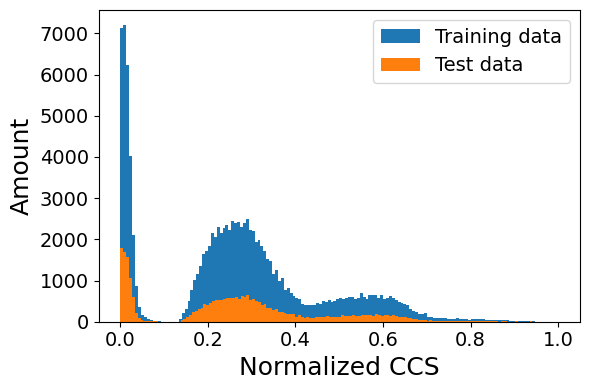

In [267]:
# plot distribution of CCS
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))
plt.hist(y_train, label="Training data", bins=150)
plt.hist(y_test, label= "Test data", bins=150)
#plt.title("Distribution of the splitted dataset", fontsize=18)
plt.ylabel("Amount",fontsize=18)
plt.xlabel("Normalized CCS", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("Normalized CCS.png", dpi=300)
plt.show()

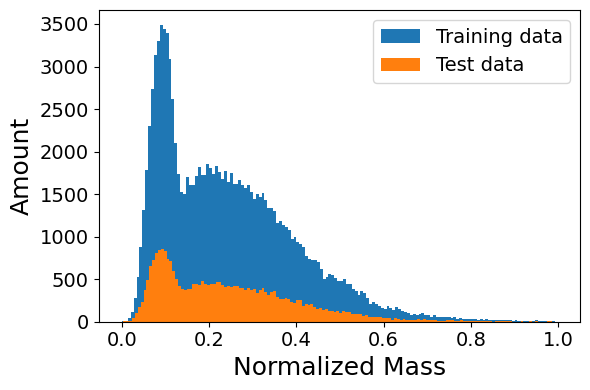

In [268]:
# plot distribution of Mass
plt.figure(figsize=(6, 4))
plt.hist(X_train["Mass"], label="Training data", bins=150)
plt.hist(X_test["Mass"], label= "Test data", bins=150)
#plt.title("Distribution of the splitted dataset", fontsize=18)
plt.ylabel("Amount",fontsize=18)
plt.xlabel("Normalized Mass", fontsize=18)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig("Normalized Mass.png", dpi=300)
plt.show()

Mean Squared Error: 0.003579948426658627
Mean Absolute Error: 0.0441257642995971
R² Score: 0.9062588782910261


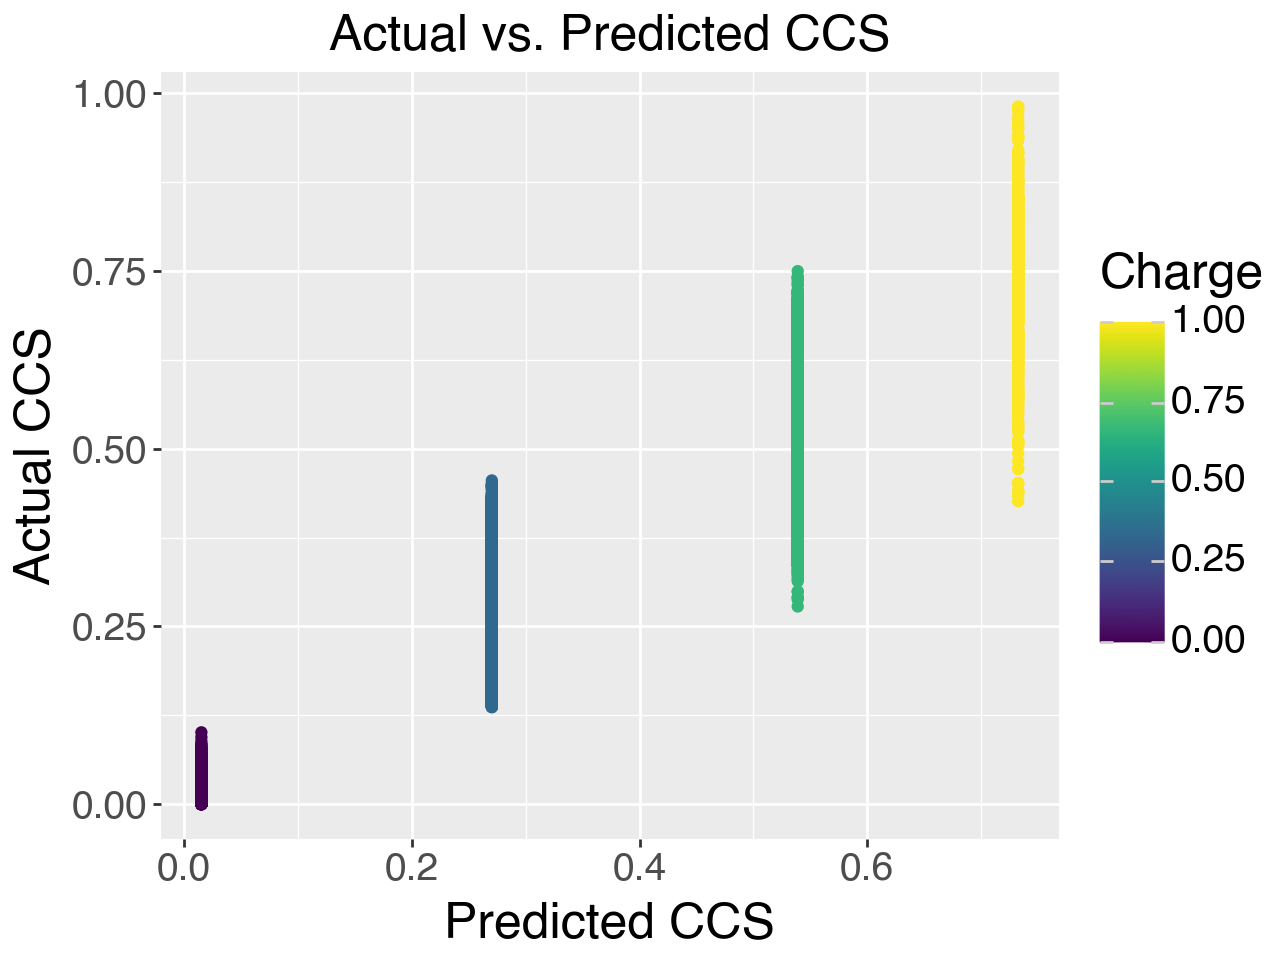

In [278]:
# Model for baseline prediction with Charge
# train first model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

cur_features = ['Charge']

modelBaseline = RandomForestRegressor(n_estimators=10, random_state=42)
modelBaseline.fit(X_train[cur_features], y_train.ravel())

# evaluate  model
y_pred = modelBaseline.predict(X_test[cur_features])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")
from matplotlib.pyplot import hist

from plotnine import ggplot, aes, geom_point, labs, scale_color_brewer, scale_color_distiller, scale_fill_gradient, theme, element_text

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)

Mean Squared Error: 0.00040582496803395166
Mean Absolute Error: 0.011666453054849573
R² Score: 0.9893734536962259


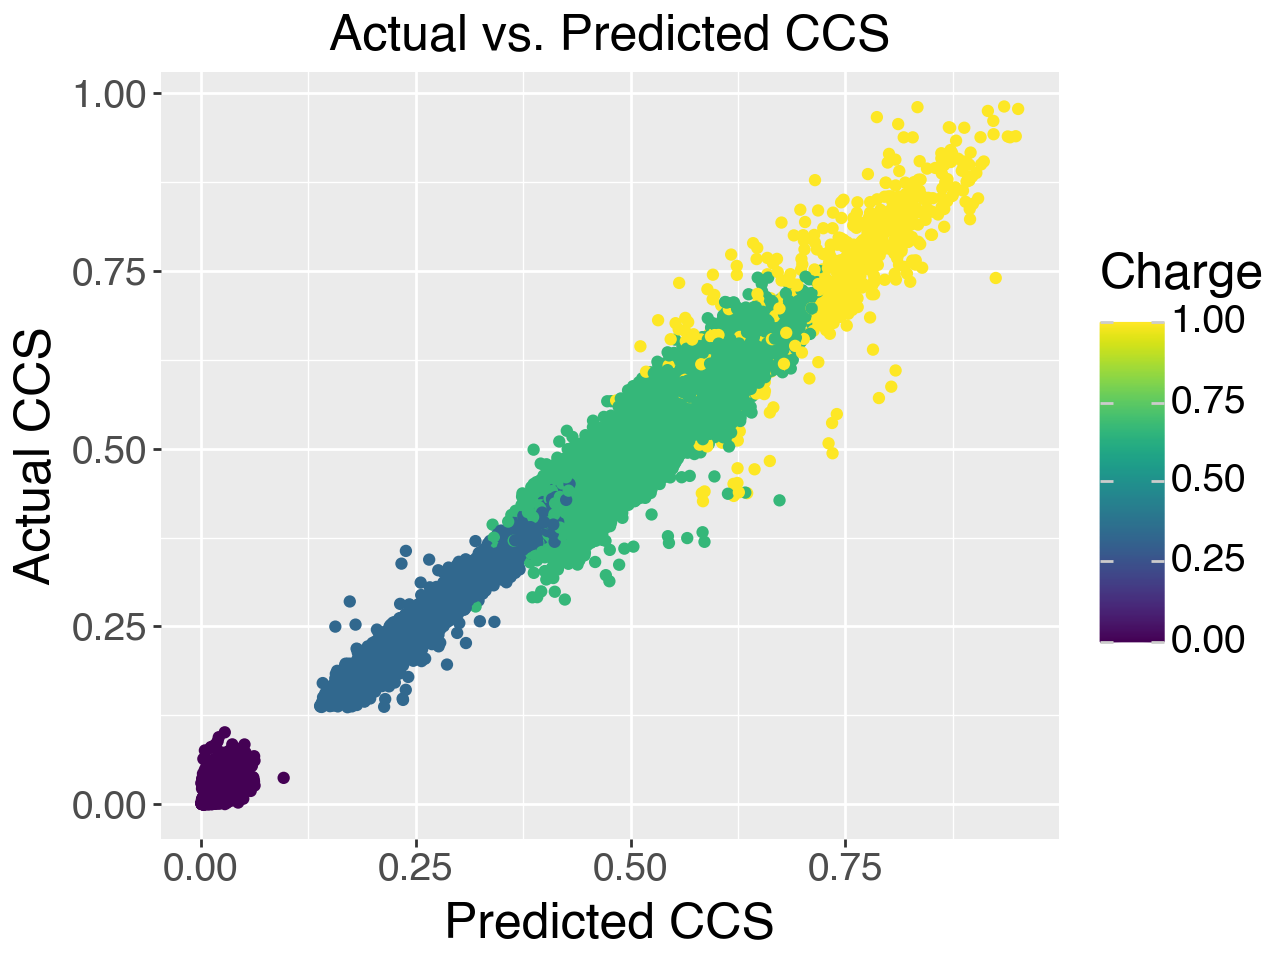

In [270]:
# Model with all relevant features
# ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

cur_features = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

modelAll = RandomForestRegressor(n_estimators=10, random_state=42)
modelAll.fit(X_train[cur_features], y_train.ravel())

# evaluate model
y_pred = modelAll.predict(X_test[cur_features])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)

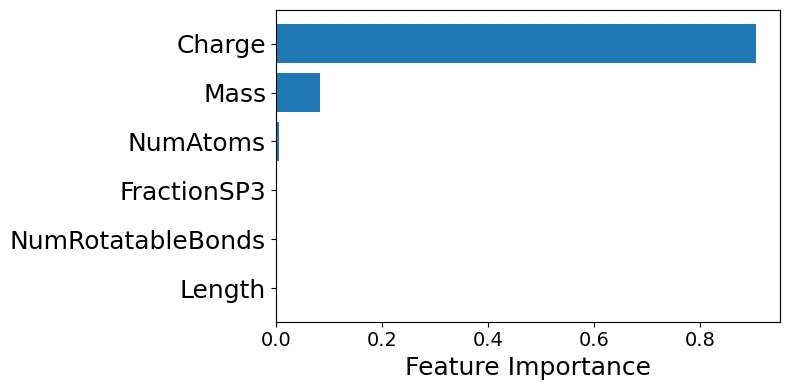

,feature,importance
0,Charge,0.905669
1,Mass,0.082958
4,NumAtoms,0.005987
5,FractionSP3,0.002822
3,NumRotatableBonds,0.001603
2,Length,0.000961


In [271]:

# Extract feature importances
importances = modelAll.feature_importances_
feature_names = ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

# Sort the features by importance
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 4))
plt.barh(feature_importances['feature'], feature_importances['importance'])
plt.xlabel('Feature Importance', fontsize=18)
#plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Reverse order to have the most important at the top
plt.xticks(fontsize=14)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.savefig("FeatureImportance.png", dpi=300)
plt.show()

feature_importances

Mean Squared Error: 0.00046839269992682113
Mean Absolute Error: 0.012177094999297004
R² Score: 0.9877351146277779


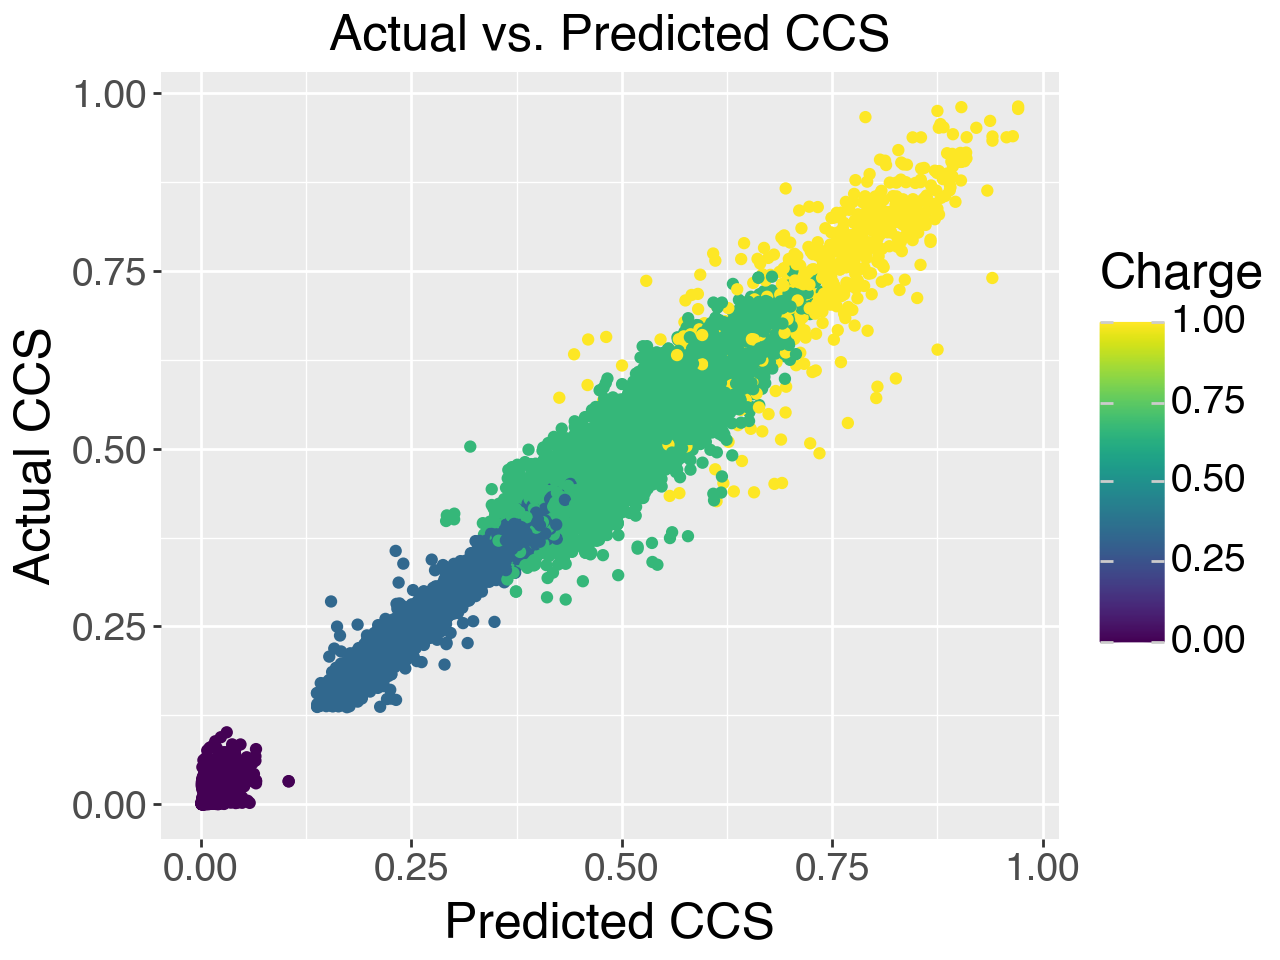

In [272]:
# Model with all relevant features
# ['Charge', 'Mass', 'Length', 'NumRotatableBonds', 'NumAtoms', 'FractionSP3']

cur_features = ['Charge', 'Mass']

model = RandomForestRegressor(n_estimators=10, random_state=42)
model.fit(X_train[cur_features], y_train.ravel())

# evaluate model
y_pred = model.predict(X_test[cur_features])
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)


In [279]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [273]:

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': list(range(1,25)),
    'max_depth': list(range(1,30)),
    'min_samples_split': list(range(1,10)),
    'max_features': list(range(1,10)),
    'min_samples_leaf': list(range(1,15))
}


random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=10, cv=5, random_state=42)
random_search.fit(X_train, y_train.ravel())

print("Beste Parameter:", random_search.best_params_)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packag

Beste Parameter: {'n_estimators': 20, 'min_samples_split': 2, 'min_samples_leaf': 14, 'max_features': 6, 'max_depth': 25}


In [274]:
# evaluate optimized model

# Output results from cross-validation
best_model = random_search.best_estimator_
scores = cross_val_score(best_model, X_train, y_train.ravel(), cv=5, scoring='r2')
print("Cross-validation scores for each fold:", scores)
print("Mean cross-validation score:", scores.mean())

# Output results from testing
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R² Score: {r2}")

Cross-validation scores for each fold: [0.99013719 0.99053942 0.99047561 0.99062577 0.99097546]
Mean cross-validation score: 0.9905506898206111
Mean Squared Error: 0.0003615721950681037
Mean Absolute Error: 0.010903347894061218
R² Score: 0.9905322146844179


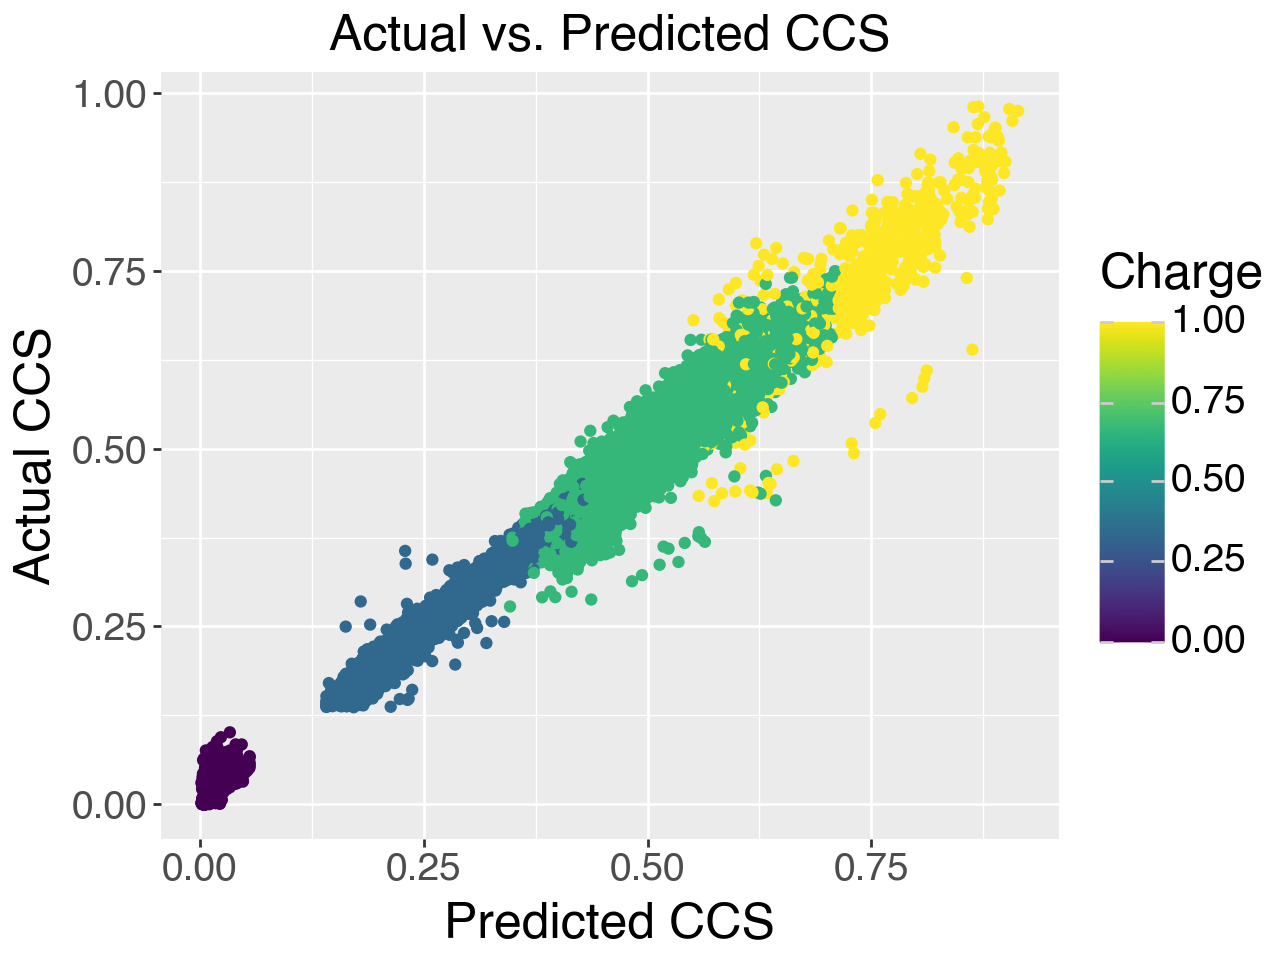

In [275]:
from plotnine import ggplot, aes, geom_point, labs, scale_color_brewer, scale_color_distiller, scale_fill_gradient, theme, element_text

df= pd.DataFrame()
df['Charge'] = X_test['Charge']
df['CCS_pred'] = y_pred
df['CCS_actual'] = y_test
(
    ggplot(df, aes(x = "CCS_pred", y = "CCS_actual", color="Charge"))
    +  labs(y = "Actual CCS", x = "Predicted CCS", title="Actual vs. Predicted CCS")
    + geom_point() 
    + theme(
        plot_title=element_text(size=18),         # Schriftgröße des Titels
        axis_title_x=element_text(size=18),       # Schriftgröße der X-Achsenbeschriftung
        axis_title_y=element_text(size=18),       # Schriftgröße der Y-Achsenbeschriftung
        legend_title=element_text(size=18), 
        axis_text_x=element_text(size=14),        # X-axis tick label font size
        axis_text_y=element_text(size=14), # Schriftgröße des Legendentitels
        legend_text=element_text(size=14)         # Schriftgröße des Legendentextes
    )
)

[learning_curve] Training set sizes: [   10   100  1000 10000 50000]
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.4s
[CV] END .................................................... total time=   2.0s
[CV] END .................................................... total time=   0.0s
[CV] END ...............................

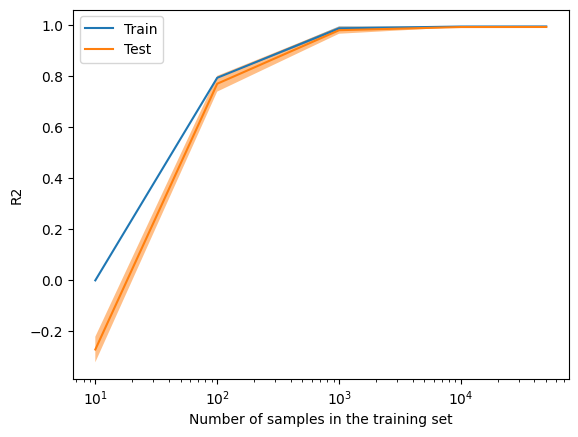

In [276]:
from sklearn.model_selection import LearningCurveDisplay

LearningCurveDisplay.from_estimator(
   estimator=best_model, X=X_train, y=y_train.ravel(), train_sizes=[10,100,1000,10000,50000], cv=5, scoring='r2', verbose=2, random_state=42)

[CV] END .....................................n_estimators=1; total time=   0.3s
[CV] END .....................................n_estimators=2; total time=   0.4s
[CV] END .....................................n_estimators=3; total time=   0.6s
[CV] END .....................................n_estimators=4; total time=   0.8s
[CV] END .....................................n_estimators=5; total time=   1.0s
[CV] END .....................................n_estimators=6; total time=   1.2s
[CV] END .....................................n_estimators=7; total time=   1.4s
[CV] END .....................................n_estimators=8; total time=   1.6s
[CV] END .....................................n_estimators=9; total time=   1.8s
[CV] END ....................................n_estimators=10; total time=   2.0s
[CV] END ....................................n_estimators=11; total time=   2.2s
[CV] END ....................................n_estimators=12; total time=   2.4s
[CV] END ...................

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:  1.9min


[CV] END ....................................n_estimators=17; total time=   3.8s
[CV] END ....................................n_estimators=18; total time=   3.9s
[CV] END ....................................n_estimators=19; total time=   4.2s
[CV] END ....................................n_estimators=20; total time=   4.6s
[CV] END ....................................n_estimators=21; total time=   4.7s
[CV] END ....................................n_estimators=22; total time=   4.8s
[CV] END ....................................n_estimators=23; total time=   5.2s
[CV] END ....................................n_estimators=24; total time=   5.6s
[CV] END .....................................n_estimators=1; total time=   0.3s
[CV] END .....................................n_estimators=2; total time=   0.5s
[CV] END .....................................n_estimators=3; total time=   0.8s
[CV] END .....................................n_estimators=4; total time=   1.1s
[CV] END ...................

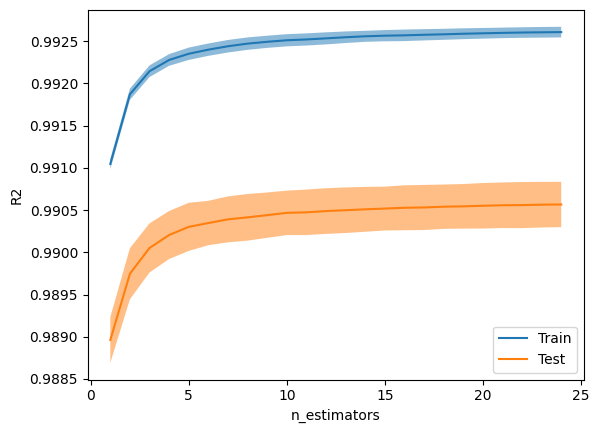

In [277]:
from sklearn.model_selection import ValidationCurveDisplay

#'neg_mean_squared_error'

ValidationCurveDisplay.from_estimator(
   best_model, X_train, y_train.ravel(), param_name="n_estimators", param_range=list(range(1,25)), scoring='r2', verbose=2)